In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append("./..")
sys.path.append(".")

In [4]:
# default libraries
import time
import datetime
import pickle
import pprint
from pathlib import Path
import math


# third party libraries
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from dotted_dict import DottedDict

# local imports
from effcn.models_multimnist import MultiMnistEffCapsNet
from effcn.functions import create_margin_loss
from effcn.utils import count_parameters
from datasets.multimnist import MultiMNist
from misc.optimizer import get_optimizer, get_scheduler


In [5]:
a = [1,2,3]

x,y,z = a

x

1

In [6]:
ds_train = MultiMNist(root='/mnt/data/datasets/multimnist_10',train=True, transform=None, generate=False)
ds_valid = MultiMNist(root='/mnt/data/datasets/multimnist_10',train=False, transform=None, generate=False)



In [7]:
dl_train = torch.utils.data.DataLoader(ds_train, 
                                    batch_size=8, 
                                    shuffle=False)

In [8]:
x,y,z,a,b = next(iter(dl_train))

In [9]:
#x,y,z,a,b =  ds_train[0]
#x2,y2,z2,a2,b2 =  ds_valid[0]

In [10]:
print(x.shape)
print(y.shape)
print(z.shape)
print(a.shape)
print(b.shape)

torch.Size([8, 1, 36, 36])
torch.Size([8])
torch.Size([8])
torch.Size([8, 1, 36, 36])
torch.Size([8, 1, 36, 36])


In [11]:
"""
# plot train imgs
x, y, z, a, b = next(iter(ds_train))
img = torchvision.utils.make_grid([x,a,b], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()
"""

'\n# plot train imgs\nx, y, z, a, b = next(iter(ds_train))\nimg = torchvision.utils.make_grid([x,a,b], nrow=8)\nimg = img.permute((1,2,0))\nplt.imshow(img)\nplt.show()\n'

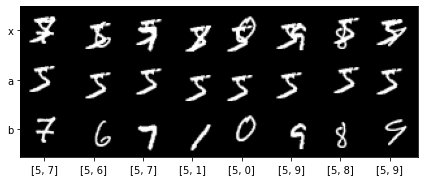

In [12]:

y_ticks = ["x", 'a', 'b']
x_ticks = torch.transpose(torch.cat((torch.unsqueeze(y,dim=0), torch.unsqueeze(z,dim=0)),dim=0), 0, 1).tolist()


img = torchvision.utils.make_grid(torch.cat([x,a,b], dim=0), nrow=x.shape[0])

#torch.cat([x,a,b], dim=0), nrow=x.shape[0])



#img = img.permute((1,2,0))

y_ticks = ["x", 'a', 'b']
x_ticks = torch.transpose(torch.cat((torch.unsqueeze(y,dim=0), torch.unsqueeze(z,dim=0)),dim=0), 0, 1).tolist()

fig, ax = plt.subplots()

ax.imshow(img.permute((1,2,0)))
ax.set_yticks((np.arange(len(y_ticks))*(x.shape[-1]+2)+(x.shape[-1]/2)), labels=y_ticks)
ax.set_xticks((np.arange(len(x_ticks))*(x.shape[-1]+2)+(x.shape[-1]/2)), labels=x_ticks)
fig.tight_layout()



#fig.savefig("/mnt/data/experiments/EfficientCN/multimnist_overfit/img_valid_xx.png")
#plt.close()

In [13]:
torch.transpose(torch.cat((torch.unsqueeze(y,dim=0), torch.unsqueeze(z,dim=0)),dim=0), 0, 1).tolist()


[[5, 7], [5, 6], [5, 7], [5, 1], [5, 0], [5, 9], [5, 8], [5, 9]]

In [14]:
x.shape[1]

1

In [15]:
np.arange(len(y_ticks))*x.shape[1]

array([0, 1, 2])

In [16]:
np.arange(len(x_ticks))*x.shape[-1]+(x.shape[-1]/2)

array([ 18.,  54.,  90., 126., 162., 198., 234., 270.])

In [17]:
x.shape[-1]

36

In [18]:
print(torch.cat([x,a,b], dim=0).shape)

print(img.shape)

torch.Size([24, 1, 36, 36])
torch.Size([3, 116, 306])


In [19]:
model = MultiMnistEffCapsNet()

model.decoder1

MultiMnistEcnDecoder(
  (layers): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=1296, bias=True)
    (5): Sigmoid()
  )
)

In [21]:
'from effcn.layers import View, Squash

In [44]:

class Squash(nn.Module):
    def __init__(self, eps=1e-21):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        """
         IN:  (b, n, d)
         OUT: squash(x(b,n,d))
        """
        x_norm = torch.norm(x, dim=2, keepdim=True)
        #return  (x / (x_norm + self.eps))
        return (1 - 1 / (torch.exp(x_norm) + self.eps)) 
        #return (1 - 1 / (torch.exp(x_norm) + self.eps)) #* (x / (x_norm + self.eps))


In [45]:
B = Squash()
f = torch.tensor([[[1,1,0,0],[1e-21,1e-21,1e-21,1e-21]]])
B(f).sum(dim=-1)

tensor([[1.4142, 1.3331]])